In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import yfinance as yf

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout

from statsmodels.tsa.arima_model import ARIMA
from math import sqrt

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
df = yf.download("AAPL", start="2015-01-01", end="2024-01-01")
company = 'Apple'


# Create a new dataframe with relevant features
data = df
data.index = pd.to_datetime(data.index)

data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.402170,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.714727,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.716955,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.049515,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,24.973557,237458000


In [ ]:
data.shape
data.dtypes

,0
Open,float64
High,float64
Low,float64
Close,float64
Adj Close,float64
Volume,int64


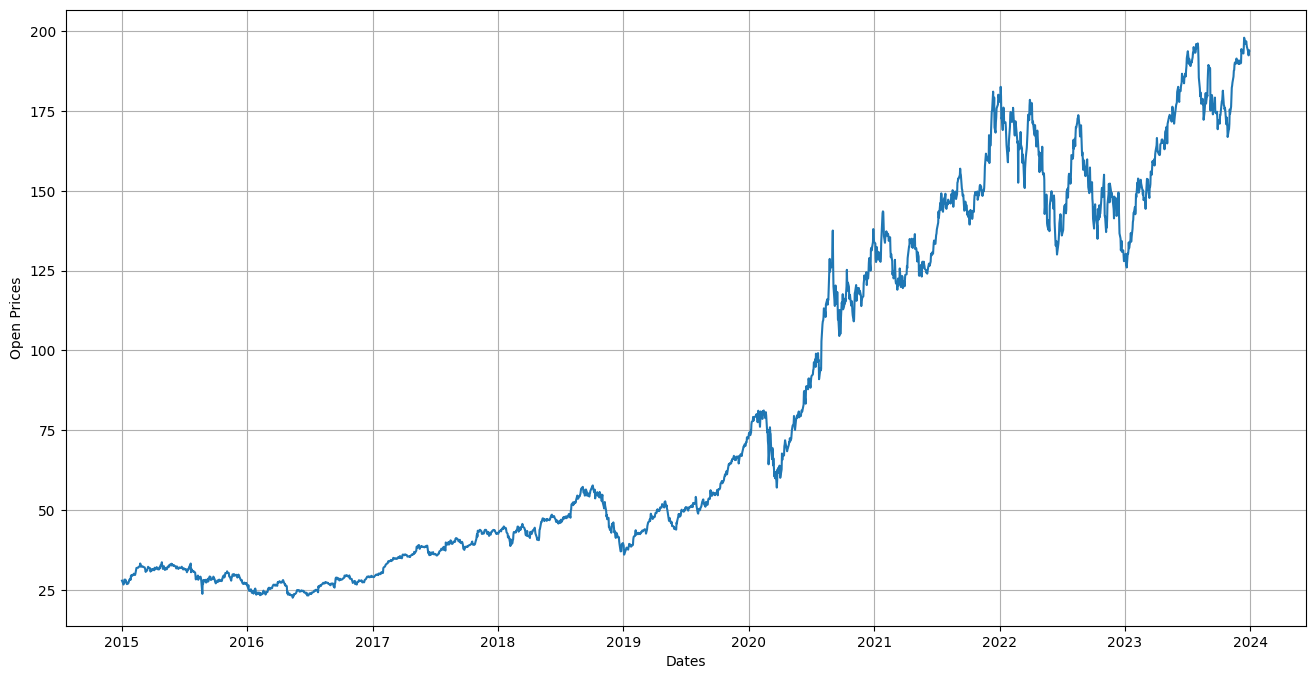

In [ ]:

plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(data['Close']);

          t-1       t+1
t-1  1.000000  0.957783
t+1  0.957783  1.000000


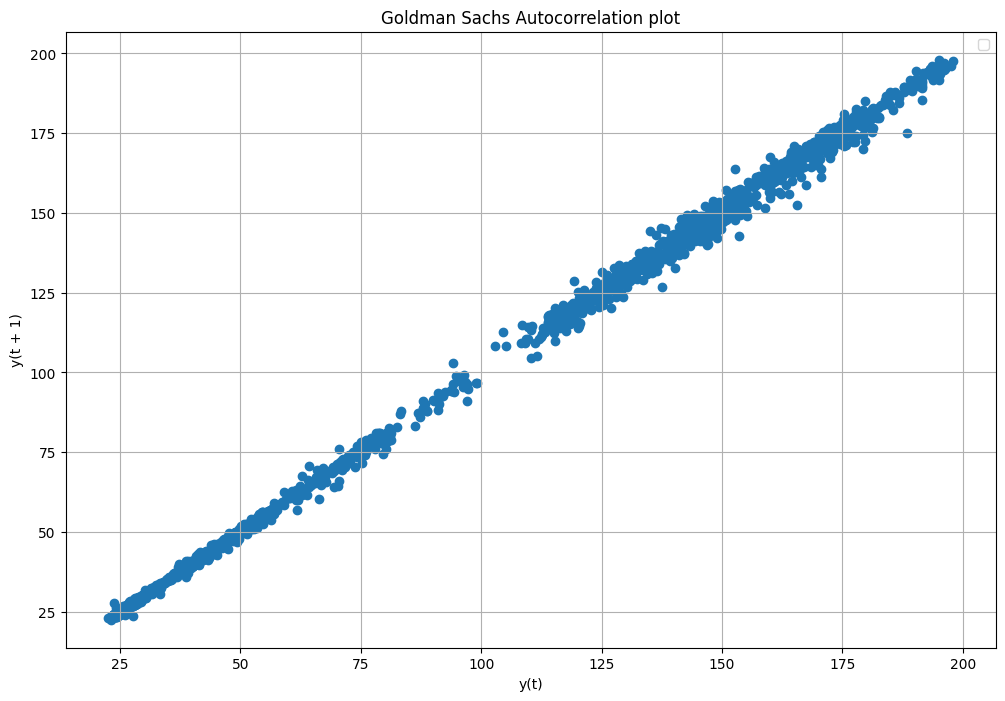

In [ ]:
from pandas.plotting import lag_plot
plt.figure(figsize=(12,8))
lag_plot(data['Close'], lag=1)
plt.title('Goldman Sachs Autocorrelation plot')
plt.grid(True)
plt.legend();

from pandas import DataFrame
from pandas import concat
values = DataFrame(data['Close'].values)
dataframe = concat([values.shift(120), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

In [ ]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.091385,37122800
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.542831,28919300
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.642548,48087700
2023-12-28,194.139999,194.660004,193.169998,193.580002,193.071426,34049900
2023-12-29,193.899994,194.399994,191.729996,192.529999,192.024185,42628800


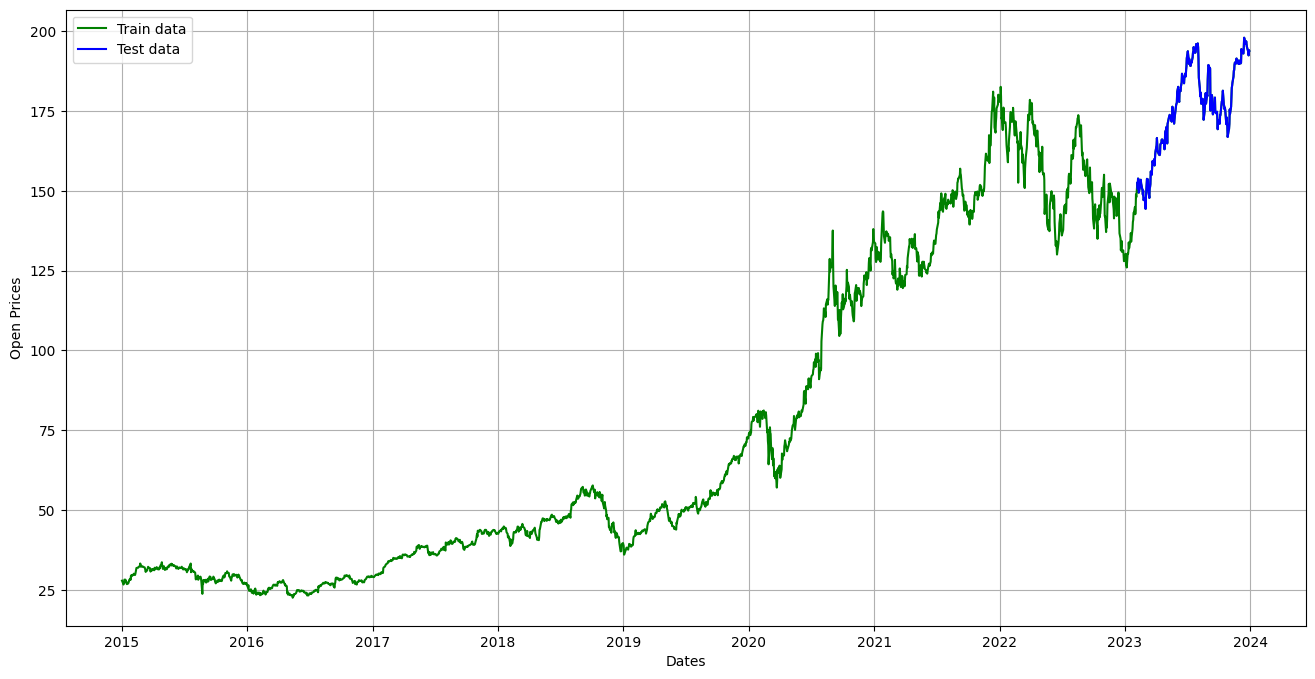

In [ ]:
train_data, test_data = data[0:int(len(data)*0.9)], data[int(len(data)*0.9):]
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(data['Close'], 'green', label='Train data')
plt.plot(test_data['Close'], 'blue', label='Test data')
plt.legend()

<Figure size 1600x800 with 0 Axes>

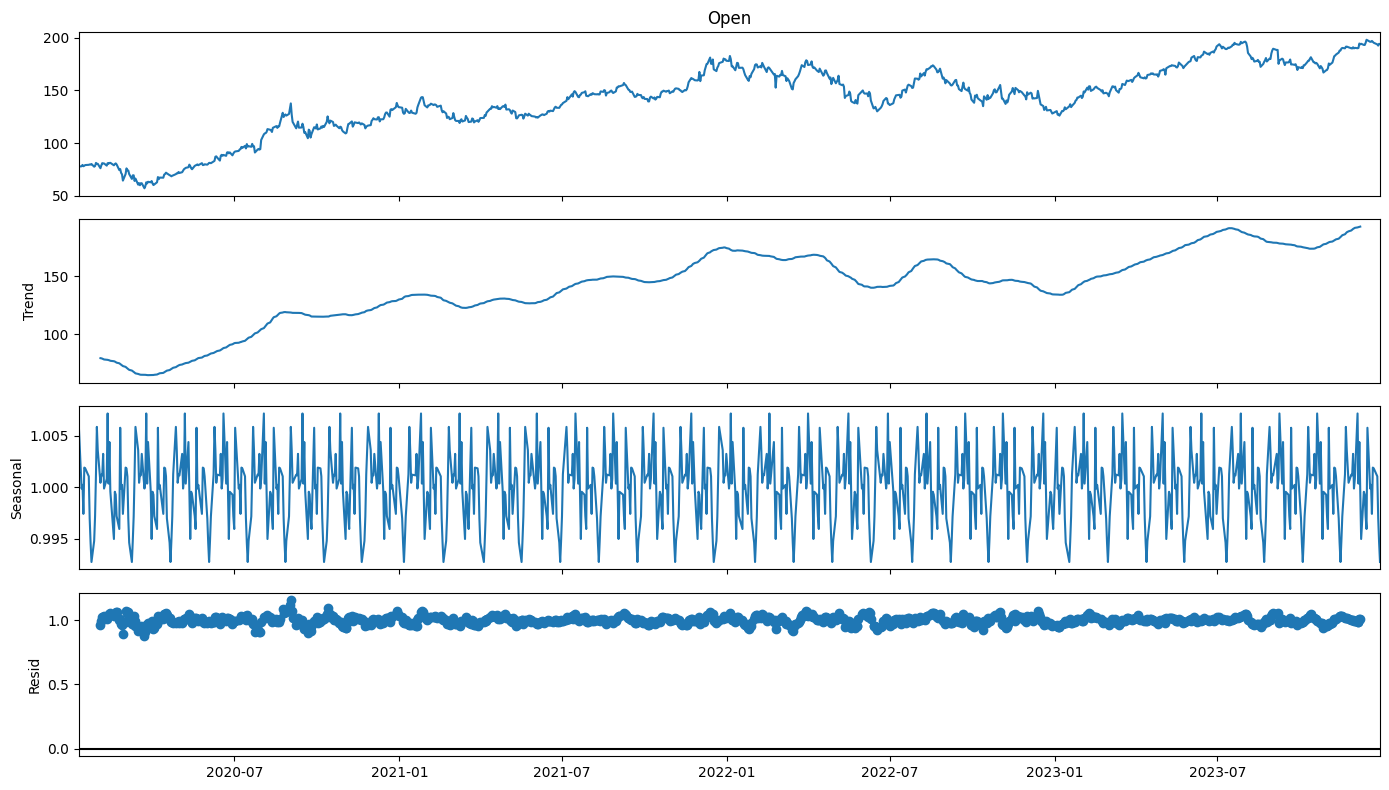

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
data_arima = data['Close']
from statsmodels.tsa.seasonal import seasonal_decompose

# Specify the period for seasonal decomposition
period = 30  # Adjust this as needed for your data

result = seasonal_decompose(data_arima[-1000:], model='multiplicative', period=period)
plt.figure(figsize=(16,8))
fig = result.plot()
plt.show()


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

train_arima = train_data['Close']
test_arima = test_data['Close']

history = [x for x in train_arima]
predictions = list()

# Make the first prediction
model = ARIMA(history, order=(1,1,0))
model_fit = model.fit()
yhat = model_fit.forecast(steps=1)[0]
predictions.append(yhat)
history.append(test_arima.iloc[0])  # Append the first observation to history

# Rolling forecasts
for i in range(1, len(test_arima)):
    # Fit model on the updated history
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
    yhat = model_fit.forecast(steps=1)[0]
    predictions.append(yhat)
    # Append the actual observation to history
    history.append(test_arima.iloc[i])

# Convert predictions to a Pandas Series for alignment
predictions_series = pd.Series(predictions, index=test_arima.index[:len(predictions)])

# Report performance
mse = mean_squared_error(test_arima, predictions_series)
print('MSE: ' + str(mse))
mae = mean_absolute_error(test_arima, predictions_series)
print('MAE: ' + str(mae))
rmse = math.sqrt(mse)
print('RMSE: ' + str(rmse))


MSE: 4.911213237994819
MAE: 1.6429152665148152
RMSE: 2.216125727027873


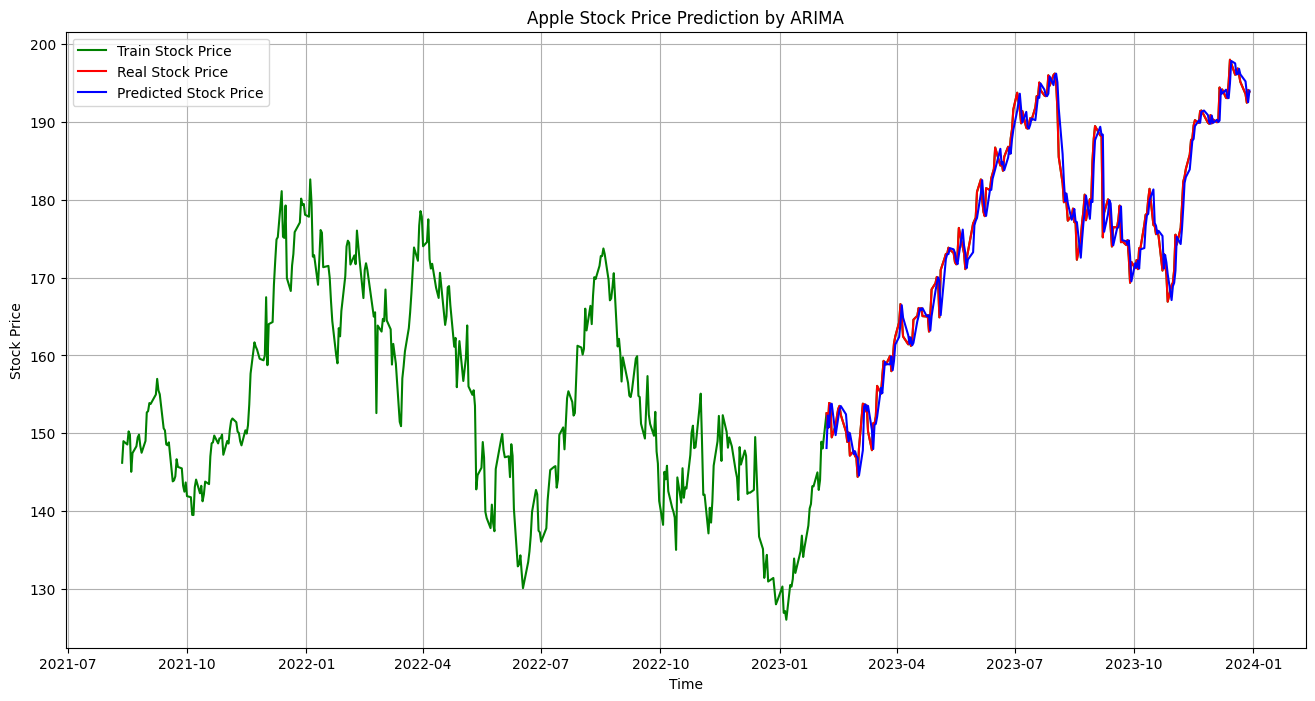

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['Close'].tail(600), color='green', label='Train Stock Price')
plt.plot(test_data.index, test_data['Close'], color='red', label='Real Stock Price')
plt.plot(test_data.index, predictions_series, color='blue', label='Predicted Stock Price')
plt.title('Apple Stock Price Prediction by ARIMA')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.savefig('arima_model.pdf')
plt.show()

In [ ]:
train = train_data.iloc[:, 0:1].values # selecting open prices

In [ ]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)

In [ ]:
timesteps = 7
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0]) # we take 30 previous prices
    y_train.append(train_scaled[i, 0]) # and 60-th price as y value
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
from numpy.random import seed
seed(2019)

In [ ]:
model = Sequential()

# Adding the first LSTM layer
# Here return_sequences=True means whether to return the last output in the output sequence, or the full sequence.
# it basically tells us that there is another(or more) LSTM layer ahead in the network.
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# Dropout regularisation for tackling overfitting
model.add(Dropout(0.20))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.25))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
# RMSprop is a recommended optimizer as per keras documentation
# check out https://keras.io/optimizers/ for more details
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 40, batch_size = 32)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.0853
Epoch 2/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0041
Epoch 3/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0032
Epoch 4/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0034
Epoch 5/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0029
Epoch 6/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0032
Epoch 7/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0027
Epoch 8/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0024
Epoch 9/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0024
Epoch 10/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0022
Epoch 11/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0025
Epoch 12/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0024
Epoch 13/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0017
Epoch 14/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0022
Epoch 15/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0020
Epo

In [ ]:
real_stock_price = test_data.iloc[:,0:1].values # taking open price

In [ ]:
combine = pd.concat((train_data['Close'], test_data['Close']), axis = 0)
# our test inputs also contains stock open Prices of last timesteps dates (as described above)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [ ]:
test_data.shape

(227, 6)

In [ ]:
# same steps as we followed while processing training data
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
# inverse_transform because prediction is done on scaled inputs
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step


<Figure size 1600x800 with 0 Axes>

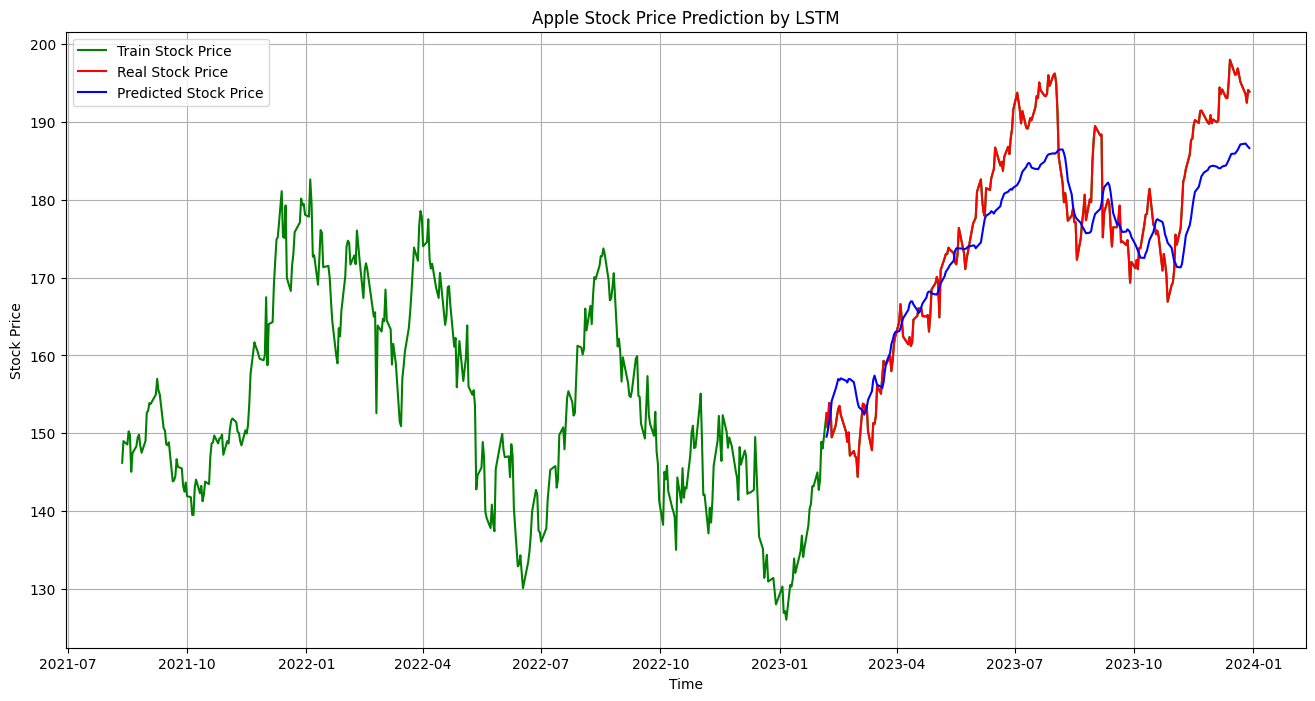

In [ ]:
# Convert indices to datetime if they are not already
data.index = pd.to_datetime(data.index)
test_data.index = pd.to_datetime(test_data.index)

plt.figure(figsize=(16,8))
plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['Close'].tail(600), color='green', label='Train Stock Price')
plt.plot(test_data.index, real_stock_price, color='red', label='Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color='blue', label='Predicted Stock Price')
plt.title('Apple Stock Price Prediction by LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.savefig('lstm_30.pdf')
plt.show()

In [ ]:
mse = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse))

MSE: 32.89126178090428
MAE: 4.765220137944831
RMSE: 5.735090389950648


In [ ]:
# Ensure predictions are aligned with test_data index
arima_predictions = predictions_series
lstm_predictions = pd.Series(predicted_stock_price.flatten(), index=test_data.index)

# Compute ensemble predictions (simple average)
ensemble_predictions = (arima_predictions + lstm_predictions) / 2

# Create DataFrame
results_df = pd.DataFrame({
    'Date': test_data.index,
    'Real Stock Price': real_stock_price.flatten(),
    'ARIMA Prediction': arima_predictions,
    'LSTM Prediction': lstm_predictions,
    'Ensemble Prediction': ensemble_predictions
})

# Set Date as index
results_df.set_index('Date', inplace=True)

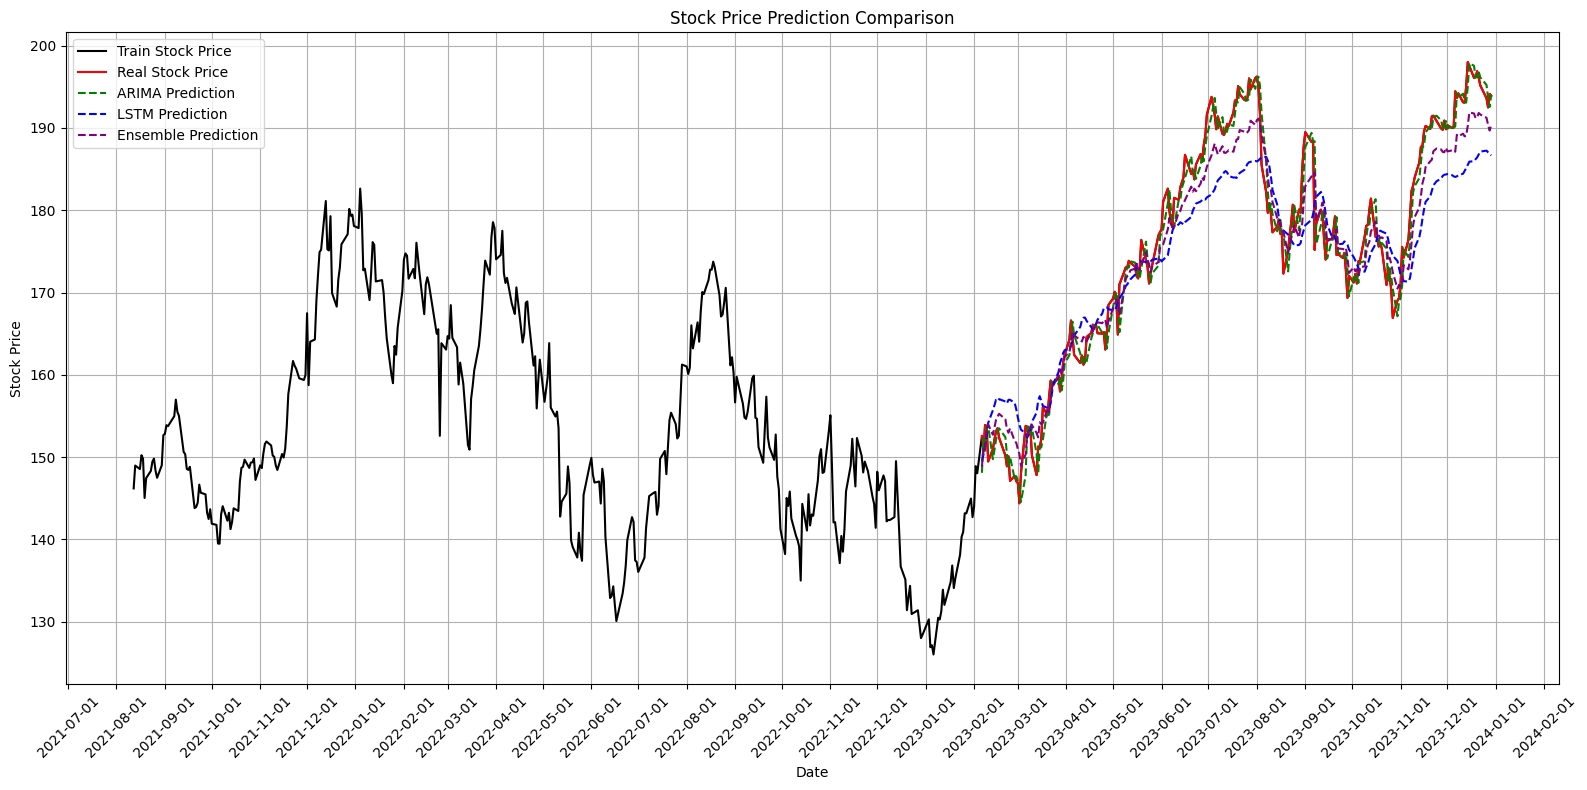

In [ ]:


plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['Close'].tail(600), color='black', label='Train Stock Price')
plt.plot(results_df.index, results_df['Real Stock Price'], color='red', label='Real Stock Price')
plt.plot(results_df.index, results_df['ARIMA Prediction'], color='green', linestyle='--', label='ARIMA Prediction')
plt.plot(results_df.index, results_df['LSTM Prediction'], color='blue', linestyle='--', label='LSTM Prediction')
plt.plot(results_df.index, results_df['Ensemble Prediction'], color='purple', linestyle='--', label='Ensemble Prediction')

# Formatting x-axis for dates
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

plt.title('Stock Price Prediction Comparison')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('ensemble_model_comparison.pdf')
plt.show()
